## Install dependencies

In [21]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "insyall" - maybe you meant "install"
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
from git import Repo

ModuleNotFoundError: ignored

In [10]:
from google.colab import output
output.enable_custom_widget_manager()

In [11]:
from google.colab import output
output.disable_custom_widget_manager()

## Parse data from git repository

In [24]:
!pip install GitPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import os
import json
from datetime import datetime

from git import Repo


def is_fix_commit(c):
    return "fix" in c.message.lower()


NAME = "angular"
GIT_URL = "https://github.com/angular/angular"
BRANCH = "main"
COMMITS_LIMIT = 1000

try:
    Repo.clone_from(GIT_URL, f"input/{NAME}")
    print("Cloned")
except:
    print("Already cloned")

if not os.path.exists("output"):
    os.makedirs("output")

analyse_repo = Repo(f"input/{NAME}")
analyse_data = []
commits_count = len(list(analyse_repo.iter_commits(BRANCH))[:COMMITS_LIMIT])
changed_files = set()
start_time = datetime.now()

print(f"Start analyse {NAME}\nTotal commits:", commits_count)
for index, commit in enumerate(list(analyse_repo.iter_commits(BRANCH))[:COMMITS_LIMIT][::-1]):
    if commit.message.startswith("Merge"):
        continue

    if index % 100 == 0:
        print(f"Analyse {index} of {commits_count}\n"
              f"Elapsed time: {datetime.now() - start_time}\n"
              f"For one commit: {(datetime.now() - start_time) / (index + 1)}\n"
              f"Estimated time: {(datetime.now() - start_time) / (index + 1) * (commits_count - index)}\n")
        json.dump(analyse_data, open(f"output/analyse_data_{NAME}.json", "w"), indent=4)
    if index % 2000 == 0:
      json.dump(analyse_data, open(f"output/analyse_data_{NAME}__snap.json", "w"), indent=4)

    for file in commit.stats.files:
        if is_fix_commit(commit):
            for a in analyse_data[::-1]:
                if a["file"] == file:
                    a["is_broken"] = True
                    break

        analyse_data.append({
            "file": file,
            "author": commit.author.name,
            "msg": commit.message,
            "date": int(commit.committed_datetime.timestamp()),
            "is_broken": False,
        })

json.dump(analyse_data, open(f"output/analyse_data_{NAME}.json", "w"), indent=4)

print(
    f"Ready! Elapsed time: {datetime.now() - start_time}\n"
    f"For one commit: {(datetime.now() - start_time) / commits_count}\n"
)


Already cloned
Start analyse angular
Total commits: 1000
Analyse 0 of 1000
Elapsed time: 0:00:00.679946
For one commit: 0:00:00.679977
Estimated time: 0:11:19.984000

Analyse 100 of 1000
Elapsed time: 0:00:02.931577
For one commit: 0:00:00.029026
Estimated time: 0:00:26.123400

Analyse 200 of 1000
Elapsed time: 0:00:05.390021
For one commit: 0:00:00.026816
Estimated time: 0:00:21.452800

Analyse 300 of 1000
Elapsed time: 0:00:07.878123
For one commit: 0:00:00.026173
Estimated time: 0:00:18.321100

Analyse 400 of 1000
Elapsed time: 0:00:10.199760
For one commit: 0:00:00.025436
Estimated time: 0:00:15.261600

Analyse 500 of 1000
Elapsed time: 0:00:12.508429
For one commit: 0:00:00.024967
Estimated time: 0:00:12.483500

Analyse 600 of 1000
Elapsed time: 0:00:14.876408
For one commit: 0:00:00.024753
Estimated time: 0:00:09.901200

Analyse 700 of 1000
Elapsed time: 0:00:17.194748
For one commit: 0:00:00.024529
Estimated time: 0:00:07.358700

Analyse 800 of 1000
Elapsed time: 0:00:19.529308


## Train model

In [55]:
data_src = "output/analyse_data_angular.json"

df = pd.read_json(data_src)

df['date'] = df['date'].astype(str) 

df.head()

,file,author,msg,date,is_broken
0,.gitignore,Miško Hevery,Initial commit\n,2014-09-18 16:12:01,False
1,LICENSE,Miško Hevery,Initial commit\n,2014-09-18 16:12:01,False
2,.gitignore,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
3,.gitmodules,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
4,TODO.md,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False


In [56]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_data, train_labels = train_df.loc[:, train_df.columns != 'is_broken'], train_df['is_broken'].astype(int)
test_data, test_labels = test_df.loc[:, train_df.columns != 'is_broken'], test_df['is_broken'].astype(int)

cat_features = [0, 1, 2, 3]
additional_metrics = ['Recall', 'Precision', 'Accuracy', 'F1']

In [57]:
model = CatBoostClassifier(
    cat_features=cat_features,
    random_seed=2,
    custom_metric=additional_metrics,
    train_dir = "bccommits"
)

In [58]:
model.fit(train_data, train_labels)

Learning rate set to 0.087766
0:	learn: 0.6559473	total: 142ms	remaining: 2m 21s
1:	learn: 0.6264287	total: 263ms	remaining: 2m 11s
2:	learn: 0.5824470	total: 432ms	remaining: 2m 23s
3:	learn: 0.5515974	total: 570ms	remaining: 2m 21s
4:	learn: 0.5241461	total: 683ms	remaining: 2m 15s
5:	learn: 0.5064145	total: 793ms	remaining: 2m 11s
6:	learn: 0.4906016	total: 915ms	remaining: 2m 9s
7:	learn: 0.4781308	total: 1.05s	remaining: 2m 10s
8:	learn: 0.4689958	total: 1.16s	remaining: 2m 8s
9:	learn: 0.4620539	total: 1.28s	remaining: 2m 6s
10:	learn: 0.4542520	total: 1.4s	remaining: 2m 5s
11:	learn: 0.4482186	total: 1.54s	remaining: 2m 6s
12:	learn: 0.4422645	total: 1.66s	remaining: 2m 6s
13:	learn: 0.4366854	total: 1.81s	remaining: 2m 7s
14:	learn: 0.4321035	total: 2s	remaining: 2m 11s
15:	learn: 0.4286272	total: 2.12s	remaining: 2m 10s
16:	learn: 0.4249311	total: 2.25s	remaining: 2m 9s
17:	learn: 0.4224727	total: 2.37s	remaining: 2m 9s
18:	learn: 0.4202145	total: 2.5s	remaining: 2m 9s
19:	lea

In [59]:
model.get_feature_importance()
# Output shows importance: file, author, msg, date

array([18.80340094, 30.1818761 , 26.07227511, 24.94244785])

In [60]:
predict = model.predict(test_data)

## Learn metrics

In [61]:
print(f"Precision: {precision_score(test_labels.astype(int), pd.DataFrame(predict)[0].astype(int))}")

Precision: 0.7155666251556663


In [62]:
import json

import pandas as pd

learn_info = dict.fromkeys(['Logloss'] + additional_metrics , [])
df = pd.DataFrame.from_dict(learn_info)

with open("bccommits/catboost_training.json", "r") as f:
    data = json.load(f)

for index, i in enumerate(data["iterations"]):
  df.loc[index] = i['learn']

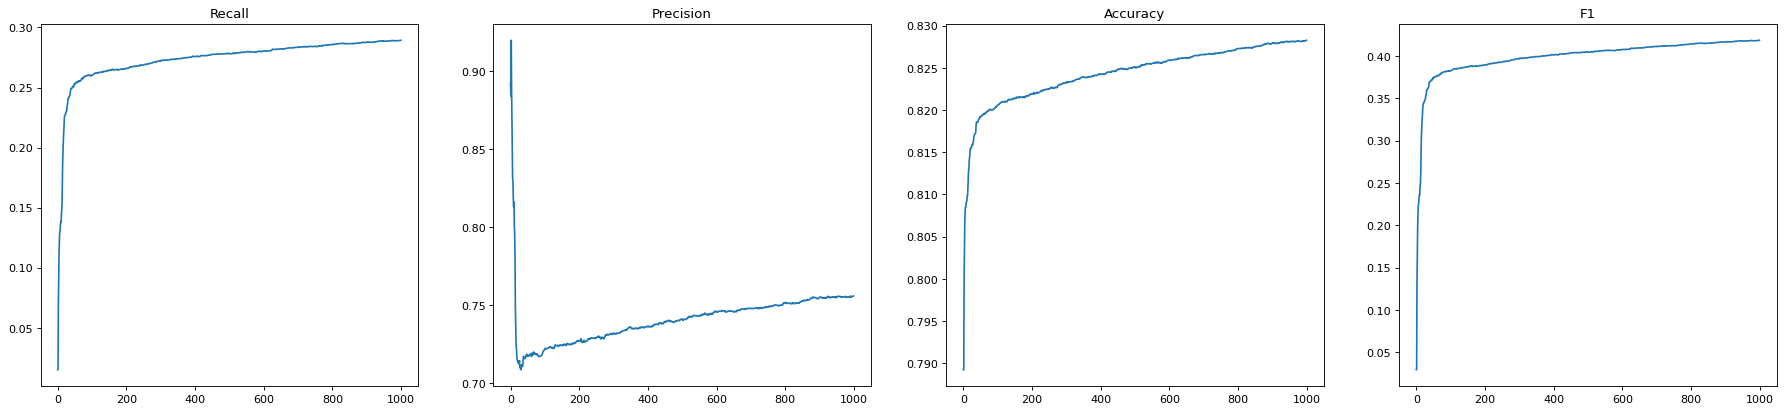

In [63]:
from matplotlib.pyplot import figure

fig, axs = plt.subplots(1, 4, figsize=(28, 6), dpi=80)

df['Recall'].plot(ax=axs[0], title="Recall")
df['Precision'].plot(ax=axs[1], title="Precision")
df['Accuracy'].plot(ax=axs[2], title="Accuracy")
df['F1'].plot(ax=axs[3], title="F1")


## Predict for custom data

In [64]:
test = {"file": ["abc.js", ".gitignore", "modules/examples/src/todo/index.html"],
        "author": ["Ilya", "Miško Hevery", "Tobias Bosch"],
        "msg": ["Test commit", "Initial commit", "refactor: always use js2dart traceur and make examples run again"],
        "date": [1669308352, 1411056721, 1411615259]}

test_df = pd.DataFrame.from_dict(test)
test_df
test_df["date"] = test_df['date'].astype(str)

data = model.predict_proba(test_df)

data[0:,0]

array([0.72520388, 0.81297186, 0.81142785])